In [4]:
import numpy as np
import json
import matplotlib.pyplot as plt
from pprint import pprint as pp
import networkx as nx

In [5]:
from braket.aws import AwsDevice

qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

# Capabilities, constraints and performance metrics are stored as 'paradigm' attribute of AwsDevice.
capabilities = qpu.properties.paradigm
#pp(capabilities.dict())

# get C6 coefficient in rad m^6/sec Pull from capabilities attribute
C6 = float(capabilities.rydberg.dict()['c6Coefficient'])

You have 93 atoms in your graph


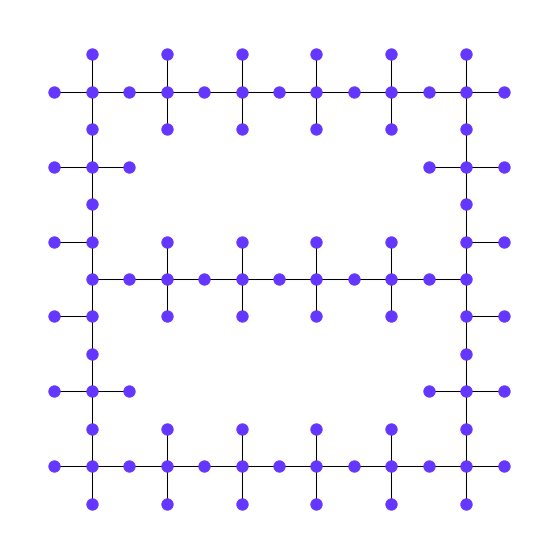

In [6]:
from iquhack_utils import visualize_graph
from math import sqrt

def kings_graph(numx,numy,filling=0.7,seed=None,branch_adjust_factor=1, scale=1):
    points = set()
    x_len, y_len = 11, 11
    
    # Builds along y-axis
    for x in [0, x_len-1]:
        for y in range(y_len):
            points.add((x,y))
            
    # Builds along x-axis
    for x in range(x_len):
        for y in [0, 5, y_len-1]:
            points.add((x,y))
            
    branch_adjust_factor_large = branch_adjust_factor
    branch_adjust_factor_small = 1-branch_adjust_factor_large
    
    # Builds branches along outer y-axis
    x_coords = [0-branch_adjust_factor_large,
                x_len-1+branch_adjust_factor_large]
    for x in x_coords:
        for y in range(0, y_len, 2):
            if (x,y) not in [(1, 4), (1, 6), (x_len-2, 4), (x_len-2, 6)]:
                points.add((x,y))
                
    # Builds branches along inner y-axis
    x_coords = [1-branch_adjust_factor_small, 
                x_len-2+branch_adjust_factor_small]
    for x in x_coords:
        for y in range(2, y_len-2, 2):
            if (x,y) not in [(x_coords[0], 4), (x_coords[0], 6), (x_coords[1], 4), (x_coords[1], 6)]:
                points.add((x,y))
            
    # Builds branches along outer x-axis
    y_coords = [-1+branch_adjust_factor_small,
                y_len-branch_adjust_factor_small]
    for y in y_coords:
        for x in range(0, x_len, 2):
            points.add((x,y))
            
    
    # Builds branches along inner x-axis
    y_coords = [1-branch_adjust_factor_small,
                4+branch_adjust_factor_small,
                6-branch_adjust_factor_small,
                y_len-2+branch_adjust_factor_small]
    for y in y_coords:
        for x in range(2, x_len-2, 2):
            points.add((x,y))
    
    
    assert len(points) <= 100
    print(f"You have {len(points)} atoms in your graph")
    points = [(x*scale, y*scale) for (x, y) in points]
    points = np.array(points)
    
    # Generate a unit disk graph by thresholding distances between points.
    distances = np.sqrt((points[:,0] - points[:,0,None])**2 + (points[:,1] - points[:,1,None])**2)
    graph     = nx.Graph(distances<np.sqrt(np.sqrt(scale**2 + scale**2))+1E-10)

    graph.remove_edges_from(nx.selfloop_edges(graph))
    return points, graph

# Make a small king's graph
pos,small_G = kings_graph(8,3,0.7,seed = 1)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
visualize_graph(ax,small_G,pos)
plt.show()

In [7]:
def find_UDG_radius(position, graph):
    '''
    Computes the optimal unit disk radius for a particular set of positions and graph.
    position   - [N x 2] array of points
    graph       - network connectivity graph. This should be a unit disk graph.
    
    returns
    radius      - Optimal unit disk radius of the graph
    rmin        - Minimum distance
    rmax        - Maximum distance
    '''
    
    dists = np.sqrt((position[:,0,None] - position[:,0])**2
               + (position[:,1,None] - position[:,1])**2)
    rmin = 0
    rmax = np.inf
    for i in range(position.shape[0]):
        for j in range(i+1,position.shape[0]):
            if (i,j) in graph.edges:
                if rmin<dists[i,j]:
                    rmin = dists[i,j]
            elif (i,j) not in graph.edges:
                if rmax>dists[i,j]:
                    rmax = dists[i,j]
    
    if rmin>rmax:
        print(rmin,rmax)
        raise BaseException("Graph is not a unit disk graph!")
    
    return np.sqrt(np.sqrt(rmax*rmin)*rmax),rmin,rmax

# Find unit disk radius
unitdisk_radius,min_radius,max_radius = find_UDG_radius(pos,small_G)

In [8]:
from iquhack_utils import get_blockade_radius,C6
Delta_final = 20e6 # rad/sec

# Find blockade radius
blockade_radius = get_blockade_radius(Delta_final, 0) # no rabi amplitude at the end
print('Blockade radius of Rydberg system is {:0.3e}m'.format(blockade_radius))
print('Unit disk radius of logical graph is {:0.3f}'.format(unitdisk_radius))

# Compute scaling value a, which converts between logical and physical coordinates
#goal_a = 5.688265828422742e-06
a = blockade_radius / unitdisk_radius
#blockade_radius = goal_a * unitdisk_radius
print(f"a: {a}")

# Generate the atom register
from braket.ahs.atom_arrangement import AtomArrangement
small_register = AtomArrangement()
for x in pos:
    small_register.add((a * x).round(7))
    
    
from plotting import show_register
a_scale=1.5#1.188
#show_register(small_register,blockade_radius=blockade_radius)


Blockade radius of Rydberg system is 8.044e-06m
Unit disk radius of logical graph is 1.297
a: 6.203097871350548e-06


[0.00e+00 1.70e-07 3.30e-07 5.00e-07 6.70e-07 8.30e-07 1.00e-06 1.17e-06
 1.33e-06 1.50e-06 1.67e-06 1.83e-06 2.00e-06 2.17e-06 2.33e-06 2.50e-06
 2.67e-06 2.83e-06 3.00e-06 3.17e-06 3.33e-06 3.50e-06 3.67e-06 3.83e-06
 4.00e-06]


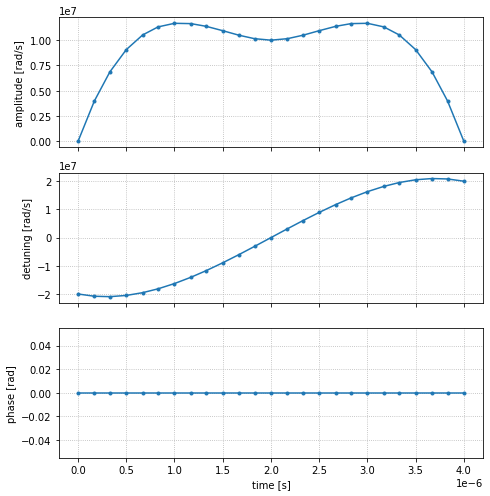

In [9]:
# Define the strength of the transverse field Ω
amplitude_min = 0
amplitude_max = 10e6  # rad / sec

# Define the strength of the detuning Δ
Delta_initial = -20e6     # rad / sec
Delta_final = Delta_final # Defined above

# Define the total drive
from quera_ahs_utils.plotting import show_global_drive
from quera_ahs_utils.drive import get_drive
from scipy.interpolate import CubicSpline, interp1d

# Magic
fixed_time      = [0, 0.6e-6, 2e-6, 3.4e-6, 4e-6]
amplitude_fixed = [amplitude_min, amplitude_max, amplitude_max, amplitude_max, amplitude_min]  # piecewise linear
detuning_fixed  = [Delta_initial, Delta_initial, 0, Delta_final, Delta_final]  # piecewise linear
phase_fixed     = [0, 0, 0, 0, 0]  # piecewise constant

time_points = np.round(np.linspace(0,4e-6,num=25,endpoint=True), 8)
# time_points = np.round(time_points/(10**np.round(np.log10(time_points))), 6)*10**np.round(np.log10(time_points))
amplitude_values = np.round(CubicSpline(fixed_time, amplitude_fixed)(time_points)/400)*400
detuning_values =  np.round(CubicSpline(fixed_time, detuning_fixed)(time_points)/400)*400
# phase_values =     np.interp(time_points, fixed_time, phase_fixed)
phase_values = np.zeros_like(time_points)
print(time_points)

amplitude_values[-1] = 0
# Define the drive
drive = get_drive(time_points.tolist(), amplitude_values.tolist(), detuning_values.tolist(), phase_values.tolist())
show_global_drive(drive);

In [10]:
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
pos,G = kings_graph(8,3,0.7,seed = 1)
#pos,small_G = kings_graph(8,3,0.7,seed = 1)


# Determine the scaling factor a
blockade_radius = (C6/(Delta_final))**(1/6)
unitdisk_radius,min_radius,max_radius = find_UDG_radius(pos,G)
a = blockade_radius / unitdisk_radius
#blockade_radius = goal_a * unitdisk_radius

print('Lattice constant is {:0.3f}um'.format(a*1e6))
register = AtomArrangement()
for x in pos:
    register.add([round(a * x[0],7), round(a*x[1],7)])
#show_register(register,blockade_radius = blockade_radius,show_atom_index=False)

ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)

You have 93 atoms in your graph
Lattice constant is 6.203um


In [11]:
def save_result_json(json_file,result):
    '''
    Helper function to save results locally
    '''
    result_dict = {"measurements":[]}
    for measurement in result.measurements:
        shot_result = {
            "pre_sequence":[int(qubit) for qubit in measurement.pre_sequence],
            "post_sequence":[int(qubit) for qubit in measurement.post_sequence]
                      } 
        result_dict["measurements"].append(shot_result)
        
    with open(json_file,"w") as io:
        json.dump(result_dict,io,indent=2)
        
def open_json(json_file):
    '''
    Helper function to load and open json data
    '''
    with open(json_file,"r") as io:
        return json.load(io)

# Simulator

In [49]:
from braket.devices import LocalSimulator
device = LocalSimulator("braket_ahs")

raise BaseException("Are you sure you want to run the simulator?")
ahs_run = device.run(ahs_program, shots=2)

# Results are loaded and saved to file
result  = ahs_run.result()
save_result_json("small_kings_graph_mis.json",result)

result_json = open_json("small_kings_graph_mis.json")
nmeas = len(result_json["measurements"])    
seqs = [result_json["measurements"][i]["post_sequence"] for i in [0,1,nmeas-1]]

fig = plt.figure(figsize=(25,15))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    
    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[seqs[i][j]] for j in range(len(seqs[i]))]
    #visualize_graph(ax,small_G,pos,node_colors = seqs_color)
    
#plt.show()

NameError: name 'open_json' is not defined

# Hardware

You have 93 atoms in your graph
Lattice constant is 6.203um


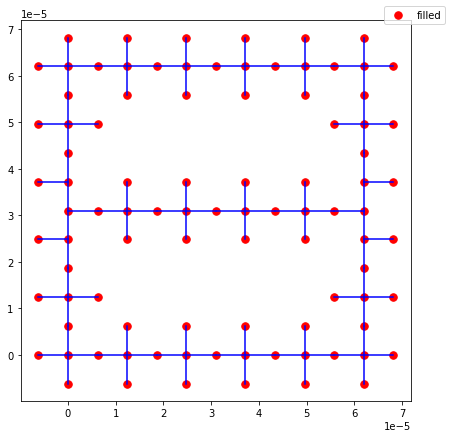

In [12]:
pos,G = kings_graph(8,3,0.7,seed = 1)

# Determine the scaling factor a
blockade_radius = (C6/(Delta_final))**(1/6)
unitdisk_radius,min_radius,max_radius = find_UDG_radius(pos,G)
a = blockade_radius / unitdisk_radius
#blockade_radius = goal_a * unitdisk_radius

print('Lattice constant is {:0.3f}um'.format(a*1e6))
register = AtomArrangement()
for x in pos:
    register.add([round(a * x[0],7), round(a*x[1],7)])
show_register(register,blockade_radius = blockade_radius,show_atom_index=False)

ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)

In [ ]:
#raise BaseException("Only run this cell when you are ready to submit your job.")
import time
file_name = time.asctime(time.localtime()).replace(" ", "_") + ".json"
print(file_name)
from braket.aws import AwsDevice
qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

nshots = 50
assert nshots <= 100
task = qpu.run(ahs_program, shots=nshots)
print(task)

save_result_json(file_name,task.result())

Sun_Jan_29_11:21:56_2023.json
AwsQuantumTask('id/taskArn':'arn:aws:braket:us-east-1:592242689881:quantum-task/5240f872-e592-4de2-85da-c2589da350d1')


In [2]:
def postprocess_MIS(G,results):
    '''
    Removes vertices that violate the independent set condition
    G - networkx graph
    results - an AWS AnalogHamiltonianSimulationQuantumTaskResult
    
    returns
    data_out - a list of bitstrings which are valid independent sets of G
    '''
    data_out = []
    for measurement in results["measurements"]: # For each measurement...
        pre_sequence = np.array(measurement["pre_sequence"])
        post_sequence = np.array(measurement["post_sequence"])
        if np.any(pre_sequence==0): continue # skip anyshots with defects
            
        bitstring = post_sequence
        inds = np.nonzero(bitstring==0)[0]    # Find indices of IS vertices
        subgraph = nx.subgraph(G,inds)        # Generate a subgraph from those vertices. If the bitstring is an independent set, this subgraph has no edges.
        
        if (not subgraph.nodes): continue
        inds2 = nx.maximal_independent_set(subgraph,seed=0) # Find the mIS of this subgraph. If there are no edges, it is the original bitstring. Else, it randomly chooses within each graph.
        payload = np.ones(len(bitstring))     # Forge into the correct data structure (a list of 1s and 0s)
        payload[inds2] = 0
        data_out.append(payload)
        
    if len(data_out) == 0: 
        raise ValueError("no independent sets found! increase number of shots.")
        
    return np.asarray(data_out)

def analysis_MIS(graph,result_json):
    '''
    Helper function to analyze a MIS result and plot data
    '''

    post_bitstrings = np.array([q["post_sequence"] for q in result_json["measurements"]])
    pp_bitstrings = postprocess_MIS(graph, result_json)


    IS_sizes = np.sum(1-pp_bitstrings,axis=1)
    unique_IS_sizes,counts = np.unique(IS_sizes,return_counts=True)


    avg_no_pp = 'Average pre-processed size:  {:0.4f}'.format( (1-post_bitstrings).sum(axis=1).mean() )
    avg_pp = 'Average post-processed IS size: {:0.4f}'.format(IS_sizes.mean())
    print(avg_no_pp)
    print(avg_pp)
    plt.bar(unique_IS_sizes,counts/counts.sum())
    plt.xticks(unique_IS_sizes)
    plt.xlabel("IS sizes",fontsize=14)
    plt.ylabel("probability",fontsize=14)
    plt.show()
    
    return IS_sizes,pp_bitstrings
    



In [3]:
def analysis(data):
    desc, filename = data
    print(desc)
    result_json = open_json(filename)
    IS_sizes,pp_bitstrings = analysis_MIS(small_G,result_json)
    ind, = np.where(IS_sizes==IS_sizes.max())
    n_show = min(len(ind),3)

    fig = plt.figure(figsize=(25,15))
    for i in range(n_show):
        ax = plt.subplot(1,n_show,i+1)

        color_lookup = {0:"r",1:'k'}
        seqs_color = [color_lookup[pp_bitstrings[ind[i]][j]] for j in range(len(pp_bitstrings[ind[i]]))]
        visualize_graph(ax,small_G,pos,node_colors = seqs_color)
    
    plt.show()


    
analysis(("big boi", file_name))



NameError: name 'file_name' is not defined

big boi


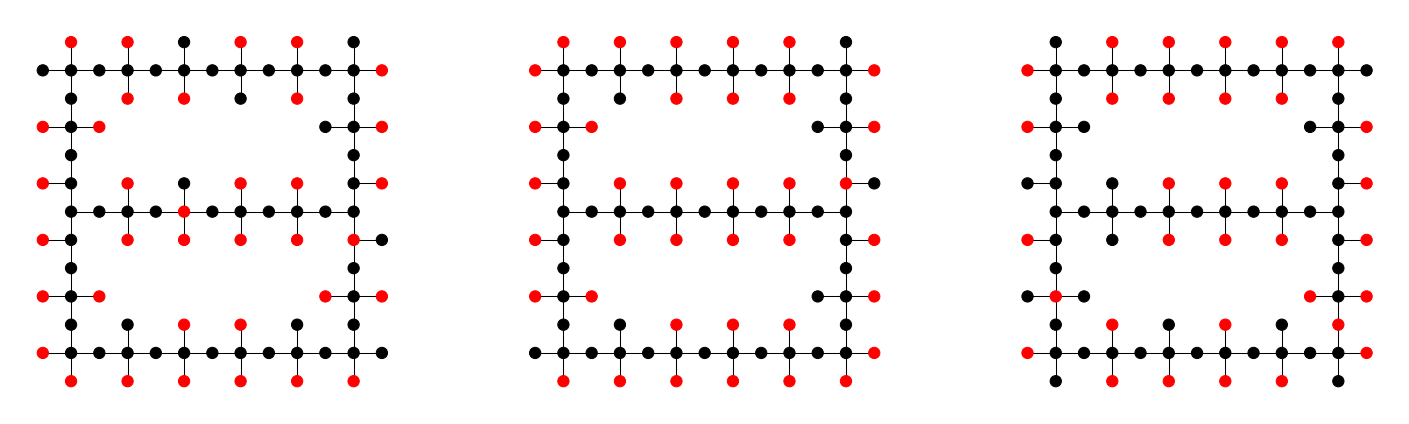

In [267]:
def plot(data):
    desc, filename = data
    print(desc)
    result_json = open_json(filename)
    nmeas = len(result_json["measurements"])
    seqs = [result_json["measurements"][i]["post_sequence"] for i in [0,nmeas-2,nmeas-1]]

    fig = plt.figure(figsize=(25,15))
    for i in range(3):
        ax = plt.subplot(1,3,i+1)

        color_lookup = {0:"r",1:'k'}
        seqs_color = [color_lookup[seqs[i][j]] for j in range(len(seqs[i]))]
        visualize_graph(ax,G,pos,node_colors = seqs_color)
    plt.show()
    
#for file in files:
#    plot(file)
plot(("big boi",file_name))